<a href="https://colab.research.google.com/github/SPThole/Pytorch-Tutorials/blob/master/pytorch_img_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [59]:
# import pandas as pd
import numpy as np
import os
# import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
# import PIL
# import skimage
from torchvision.datasets.utils import download_url
# import tarfile
import zipfile
%matplotlib inline
np.random.seed = 42


In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
device

device(type='cuda')

# Getting Kaggle datasets

In [62]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Kaggle datasets/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
# For other datasets
!kaggle datasets download -d slothkong/10-monkey-species -p Dataset

{"username":"sidhantthole6","key":"72eb99b2875edab2fe47bc8f09e9620b"}10-monkey-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [63]:
path_zip = '/content/Dataset/10-monkey-species.zip'
extract_to = '/content/Dataset/'

with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

#Looking at dataset

In [64]:
class_names = os.listdir('/content/Dataset/training/training/')

In [65]:
class_names

['n1', 'n0', 'n9', 'n3', 'n6', 'n7', 'n8', 'n4', 'n2', 'n5']

In [66]:
path_train = '/content/Dataset/training/training'
path_test = '/content/Dataset/validation/validation'

In [67]:
def show_class(class_names, path):
  i = 1
  for cl in class_names:

     plt.subplot(1,len(class_names),i)
     pth = path + '/' + cl
     files = os.listdir(pth)
     im = plt.imread(pth+ '/' + files[0])
     plt.title(cl)
     plt.imshow(im)
     i = i+1

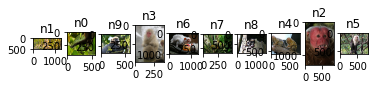

In [68]:
show_class(class_names, path_train)

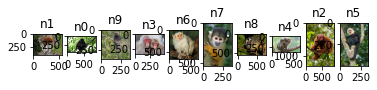

In [69]:
show_class(class_names, path_test)

# ImageFolder Dataset

In [70]:
batch_size = 128

In [71]:
transformations = transforms.Compose((transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])))

In [72]:
train_dataset = ImageFolder(path_train, 
                            transform = transformations)
test_dataset = ImageFolder(path_test,
                            transform = transformations)

In [73]:
train_loader = DataLoader(train_dataset,
                          batch_size = batch_size)
test_loader = DataLoader(test_dataset,
                          batch_size = batch_size)

In [74]:
# train_loader = train_loader.to(device)
# test_loader = test_loader.to(device)

In [75]:
for data in train_loader:
  x, y = data
  print(x.shape, y.shape)
  print(y)
  break

torch.Size([128, 3, 224, 224]) torch.Size([128])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [76]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(None, tensor(0))

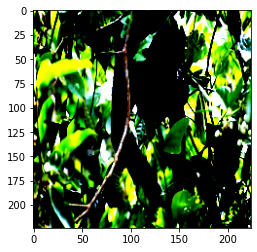

In [77]:
show(x[1]), y[1]

In [78]:
class_names.sort()
class_names_idx = dict(zip(list(np.arange(len(class_names))),class_names))

# Model

In [79]:
# model = models.vgg16(pretrained= True)
model = models.resnet18(pretrained=True)


In [80]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [81]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# for param in model.parameters():
#     param.require_grad = False
# for param in model.fc.parameters():
#     param.require_grad = True

model = model.to(device)

In [82]:
optimizer = optim.SGD(model.fc.parameters(), lr = 0.001, momentum= 0.8)
criterion = nn.CrossEntropyLoss()

In [83]:
device

device(type='cuda')

# Training

In [84]:
class train_model:

  def __init__(self, 
               train_loader,
               test_loader,
               task,
               model,
               optimizer,
               criterion,
               epochs):
    
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.task = task
    self.optimizer = optimizer
    self.criterion = criterion
    self.epochs = epochs
    self.model = model

  

  def train_it(self):
    """
    """
    self.model.train()
    history = {'train_loss':[],
                 'test_loss':[],
                 'train_score':[],
                 'test_score':[]}
    for epoch in range(self.epochs):

      for loader in self.train_loader:

        optimizer.zero_grad()
        xs, ys = loader
        xs = xs.to(device)
        ys = ys.to(device)

        preds = self.predict(xs)
        loss = self.criterion(preds,ys.reshape(-1,).long())

        loss.backward()
        self.optimizer.step()
  
        
      self.model.eval()

      history['train_loss'].append(self.calc_loss(self.train_loader))
      history['test_loss'].append(self.calc_loss(self.test_loader))
      history['train_score'].append(self.calc_score(self.train_loader))
      history['test_score'].append(self.calc_score(self.test_loader))

      if epoch%1==0:
        print(f"Iteration : {epoch}")
        
        fig = plt.figure(figsize = (12,7))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], color = 'red', label = 'Training Loss')
        plt.plot(history['test_loss'], color = 'green', label = 'Validation Loss')
        plt.legend()
        

        plt.subplot(1, 2, 2)
        plt.plot(history['train_score'], color = 'red', label = 'Training Score')
        plt.plot(history['test_score'], color = 'green', label = 'Validation Score' )
        plt.legend()
        plt.show()
        

        # fig = plt.figure()
        # ax = fig.add_subplot(111, projection = '3d')
        # ax.scatter(X[:,0], X[:,1], model(torch.tensor(X).float())[:,0].detach().numpy())
        # plt.show()
    return self.model, history

  def r2(self, xs, ys):
    return r2_score(ys.reshape(-1,), self.predict(xs).numpy())
 
  def acc(self, ys, preds):
    maxs, cls = torch.max(preds, axis = 1)
    
    return torch.sum(cls==ys.reshape(-1,)).item()/ys.shape[0]

  def predict(self,xs):
    return self.model(xs)

  def calc_loss(self,loader):
    loss = []
    for idx, data in enumerate(loader):
      xs, ys = data
      xs, ys = xs.to(device), ys.to(device)
      loss.append(self.criterion(self.predict(xs),ys.reshape(-1,).long()).item())
    return np.mean(loss)

  def calc_score(self,loader):
    scores = []
    for data in loader:
      xs, ys = data
      xs, ys = xs.to(device), ys.to(device)
      if self.task == 'reg':
          
          scores.append(self.r2(ys,self.predict(xs)))
          
      else:
          scores.append(self.acc(ys,self.predict(xs)))
    return np.mean(scores)

In [85]:
trainer = train_model(train_loader,
                      test_loader,
                      'clf',
                      model,
                      optimizer,
                      criterion,
                      25)

Iteration : 0


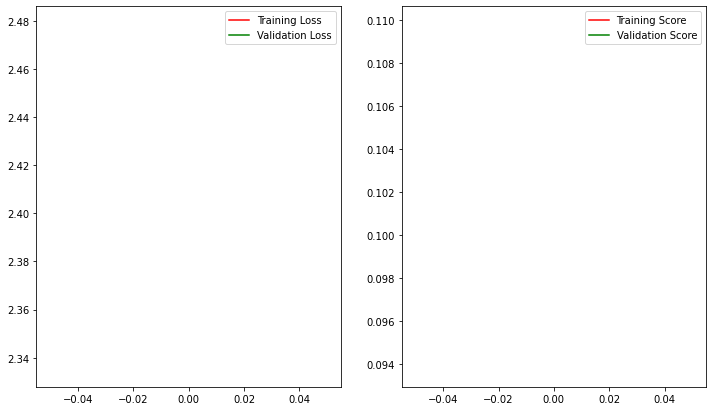

Iteration : 1


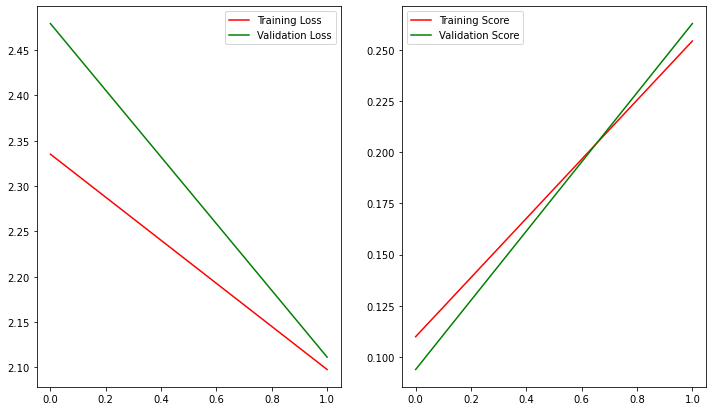

Iteration : 2


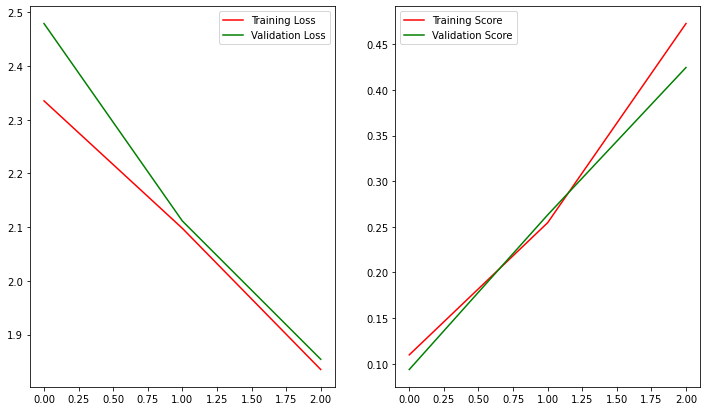

Iteration : 3


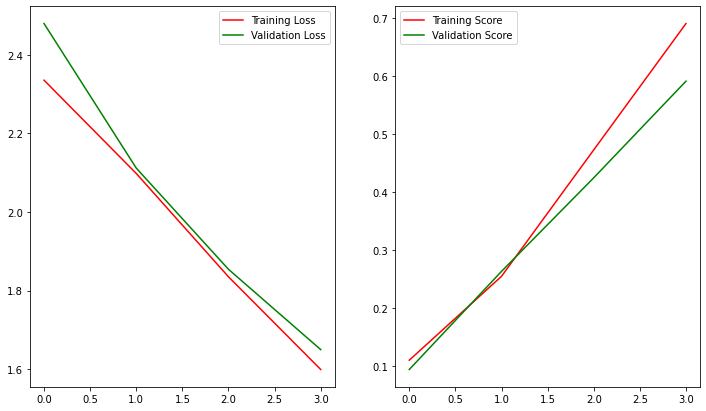

Iteration : 4


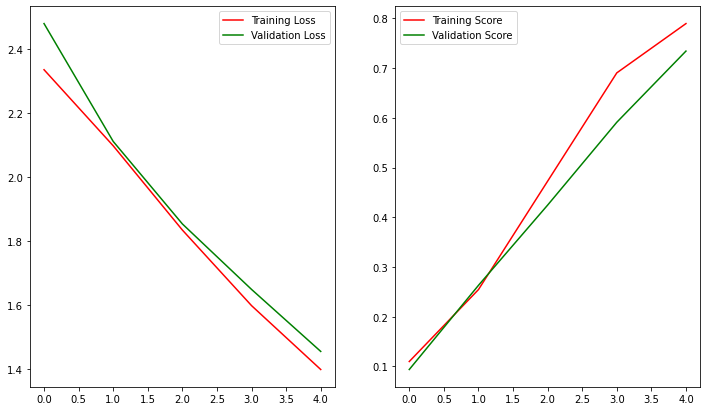

Iteration : 5


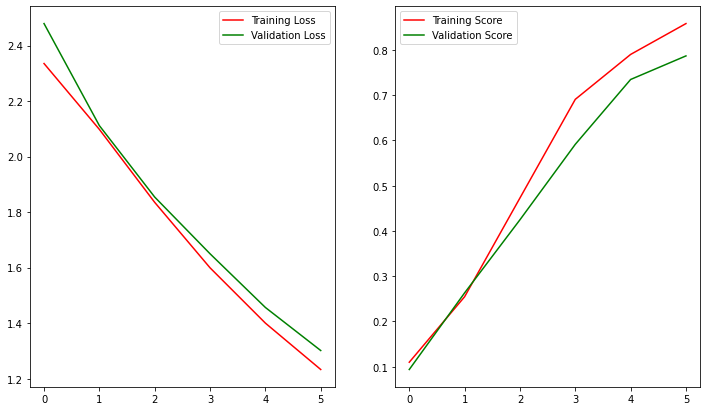

Iteration : 6


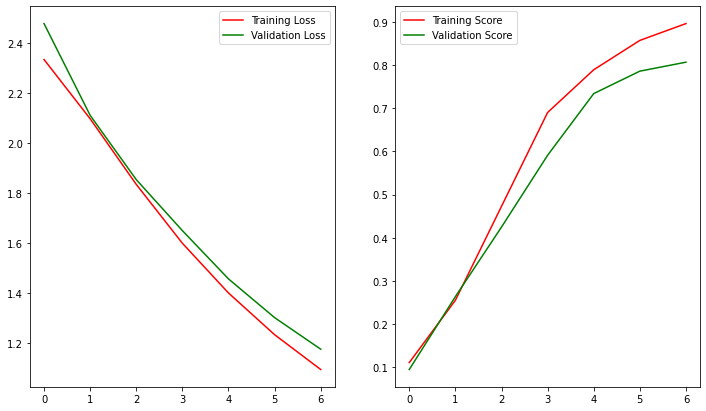

In [ ]:
model, h = trainer.train_it()
# torch.cuda.empty_cache()